# Kmeans and TSNE Visualisation:
- This is just a visualisation tool for when we might want to search for different clusters within a label. Not sure if I will use it but just thought it was pretty cool.
- Can be expanded further by integrating different algorithms through a pipeline.
https://scikit-learn.org/stable/auto_examples/neighbors/approximate_nearest_neighbors.html#sphx-glr-auto-examples-neighbors-approximate-nearest-neighbors-py

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import resample

In [13]:
class PlotClusters:
    """
    PlotClusters: A class that plots different clusters in a 3-D plot with augmentations. Easily evaluate K-means++ clusters or use DBSCAN to seperate noise from other clusters.
    Use either just the normal Kmeans++ to 3D or DBSCAN to 3D or optionally project it through TSNE. Makes it easy to quickly visualise within label groups.

    Initialisation:
        - data (pd.DataFrame): The Dataset to analyse which should have the labels filtered out.
        - scaler_type (string): Either use 'standard' or 'minmax' scaler.
        - sample_size (int): Sample a smaller size - increasing this to above 10000 significantly increasing computation for TSNE.
    """
    def __init__(self, data, scaler_type, sample_size):
        self.data = data.copy()

        # NOTE: Scaling seems to have a large impact on the number of clusters that are formed.
        if scaler_type == 'minmax':
            self.scaler = MinMaxScaler()
        elif scaler_type == 'standard':
            self.scaler = StandardScaler()
        scaled_data = self.scaler.fit_transform(self.data)
        # Resample to a more manageable size. TSNE takes a very long time.
        self.data = resample(scaled_data, n_samples=sample_size, random_state=42)

    def plot_tsne(self, apply_pca=False, n_clusters=2, lr='auto', perplexity=30, cluster_type='kmeans', eps=0.5, min_samples=20):
        """
        plot_tsne: Use KMeans++ or DBSCAN clustering and visualisate it using 3 TSNE components in a 3D map. Augments the graph for more clear interpretations.
        
        Parameters:
        - apply_pca: Whether to apply PCA before t-SNE.
        - n_clusters: Number of clusters for KMeans++ clustering.
        - lr: Learning rate for t-SNE.
        - cluster_type: Clustering type ('kmeans' or 'dbscan').
        - eps: Epsilon for DBSCAN (a type of threshold for noise which specifies the size of the ring).
        - min_samples: Minimum amount of neighbouring points or rows to consider.

        """
        # NOTE: PCA is optional as TSNE can already project the data into 3D space. PCA can speed up the processing for TSNE
        # which is complex for high dimensional data.
        data = self.data
        if apply_pca:
            pca = PCA(n_components=3)
            data = pca.fit_transform(data)
            # Print Explainability of PCA components.
            print(f"Explained Variance Ratio (PCA): {np.sum(pca.explained_variance_ratio_):.4f}")

        # Apply clustering (KMeans or DBSCAN).
        if cluster_type == 'kmeans':
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            kmeans_labels = kmeans.fit_predict(data)
            labels = kmeans_labels
        elif cluster_type == 'dbscan':
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(data)
            labels = dbscan_labels

        # Transform into a 3D space using TSNE.
        tsne = TSNE(n_components=3, random_state=42, learning_rate=lr, perplexity=perplexity)
        tsne_data = tsne.fit_transform(data)
        # Error occurs using numpy so needs to be converted.
        tsne_df = pd.DataFrame(tsne_data, columns=['v1', 'v2', 'v3'])
        tsne_df['Cluster'] = labels
        # Rotatation for the plots.
        sns.set_theme(palette="pastel")
        fig = plt.figure(figsize=(12, 10))
        views = [
            (30, 30),
            (90, 0),
            (-90, 0),
            (30, 90),
        ]
        
        for i, (elev, azim) in enumerate(views):
            ax = fig.add_subplot(2, 2, i+1, projection='3d')

            # Plots noise (-1) in red, others in a different color. Set alpha to low as it is usually the hard to see other points amongst it.
            if cluster_type == 'dbscan':
                ax.scatter(tsne_df['v1'][tsne_df['Cluster'] == -1], 
                           tsne_df['v2'][tsne_df['Cluster'] == -1], 
                           tsne_df['v3'][tsne_df['Cluster'] == -1], 
                           color='#E45E4C', label='Noise', s=50, alpha=0.1, edgecolors='#A11E0C')

                ax.scatter(tsne_df['v1'][tsne_df['Cluster'] != -1], 
                           tsne_df['v2'][tsne_df['Cluster'] != -1], 
                           tsne_df['v3'][tsne_df['Cluster'] != -1], 
                           c=tsne_df['Cluster'][tsne_df['Cluster'] != -1], 
                           cmap='tab20', s=50, alpha=0.8)

            # If KMeans, plot each cluster with a different color
            if cluster_type == 'kmeans':
                ax.scatter(tsne_df['v1'], tsne_df['v2'], tsne_df['v3'], 
                                     c=tsne_df['Cluster'], cmap='tab20', s=100, alpha=0.3, marker='o')

            ax.view_init(elev=elev, azim=azim)
        plt.suptitle(f"TSNE with {cluster_type.capitalize()}")
        plt.tight_layout()
        plt.show()

    def plot_dbscan(self, eps=0.5, min_samples=20):
        """
        plot_tsne:  DBSCAN clustering and visualisate it using 3 PCA components in a 3D map. Augments the graph for more clear interpretations.
        
        Parameters:
        - eps: Epsilon for DBSCAN (a type of threshold for noise which specifies the size of the ring).
        - min_samples: Minimum amount of neighbouring points or rows to consider.

        """

        data = self.data
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(data)

        # PCA is required for the 3D plot.
        pca = PCA(n_components=3)
        data = pca.fit_transform(data)
        # Print Explainability of PCA components.
        print(f"Explained Variance Ratio (PCA): {np.sum(pca.explained_variance_ratio_):.4f}")
        
        # Prepare DataFrame for plotting
        pca_data = pd.DataFrame(data, columns=['PC1', 'PC2', 'PC3'])
        pca_data['Cluster'] = dbscan_labels
        sns.set_theme(palette="pastel")
        fig = plt.figure(figsize=(12, 10))
        
        # Rotation of plot.
        views = [
            (30, 30),
            (90, 0),
            (-90, 0),
            (30, 90),
        ]
        
        for i, (elev, azim) in enumerate(views):
            ax = fig.add_subplot(2, 2, i+1, projection='3d')
            # Set noise to red. Alpha is set to be able to see the other clusters easier.
            ax.scatter(pca_data['PC1'][dbscan_labels == -1], pca_data['PC2'][dbscan_labels == -1], pca_data['PC3'][dbscan_labels == -1], 
                       color='#E45E4C', label='Noise', s=50, alpha=0.1, edgecolors='#A11E0C')

            ax.scatter(pca_data['PC1'][dbscan_labels != -1], pca_data['PC2'][dbscan_labels != -1], pca_data['PC3'][dbscan_labels != -1], 
                       c=dbscan_labels[dbscan_labels != -1], cmap='tab20', s=50, alpha=0.4)
            ax.view_init(elev=elev, azim=azim)
            ax.legend()
        plt.suptitle('DBSCAN Noise Clusters 3D PCA')
        plt.tight_layout()
        plt.show()

    def plot_kmeans(self, n_clusters=2):
        """
        plot_kmeans: Kmeans clustering and visualisate it using 3 PCA components in a 3D map. Augments the graph for more clear interpretations.

        Parameters:
            - n_clusters (integer): The number of clusters to try and seperarte using Kmeans++.
        """
        data = self.data

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(data)
        # PCA is required for 3D plot.
        pca = PCA(n_components=3)
        pca_data = pca.fit_transform(data)
        # Print explainability of PCA components.
        print(f"Explained Variance Ratio (PCA): {np.sum(pca.explained_variance_ratio_):.4f}")
        sns.set_theme(palette="pastel")
        fig = plt.figure(figsize=(12, 10))
        # Rotation of plot.
        views = [
            (30, 30),
            (90, 0),
            (-90, 0),
            (30, 90),
        ]
        
        for i, (elev, azim) in enumerate(views):
            ax = fig.add_subplot(2, 2, i+1, projection='3d')
            ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=kmeans_labels, 
                                 cmap='tab20', s=100, alpha=0.3, marker='o')
            ax.view_init(elev=elev, azim=azim)
        plt.suptitle('Kmeans Clusters 3D PCA')
        plt.tight_layout()
        plt.show()

In [3]:
# Read one-hot encoded Cleaned Dataset.
data = pd.read_csv('full_data_ohe.csv')
data = data.drop(columns=['Unnamed: 0'])
data = data.reset_index(drop=True)
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
# Unsupervised within label clustering uses no labels.
features = data.drop(columns=['attack_cat', 'label'])

In [15]:
# Select a subset to analyse - This would essentially be a single attack_cat.
data_analysis = data[data['attack_cat']=='Analysis']
data_normal = data[data['attack_cat']=='Normal']
# Select numerical features.
features = ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload', 'dload', 'spkts', 'dpkts',
                   'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit',
                   'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 
                   'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']

data_analysis = data_analysis[features]
data_normal = data_normal[features]

# Normal Data

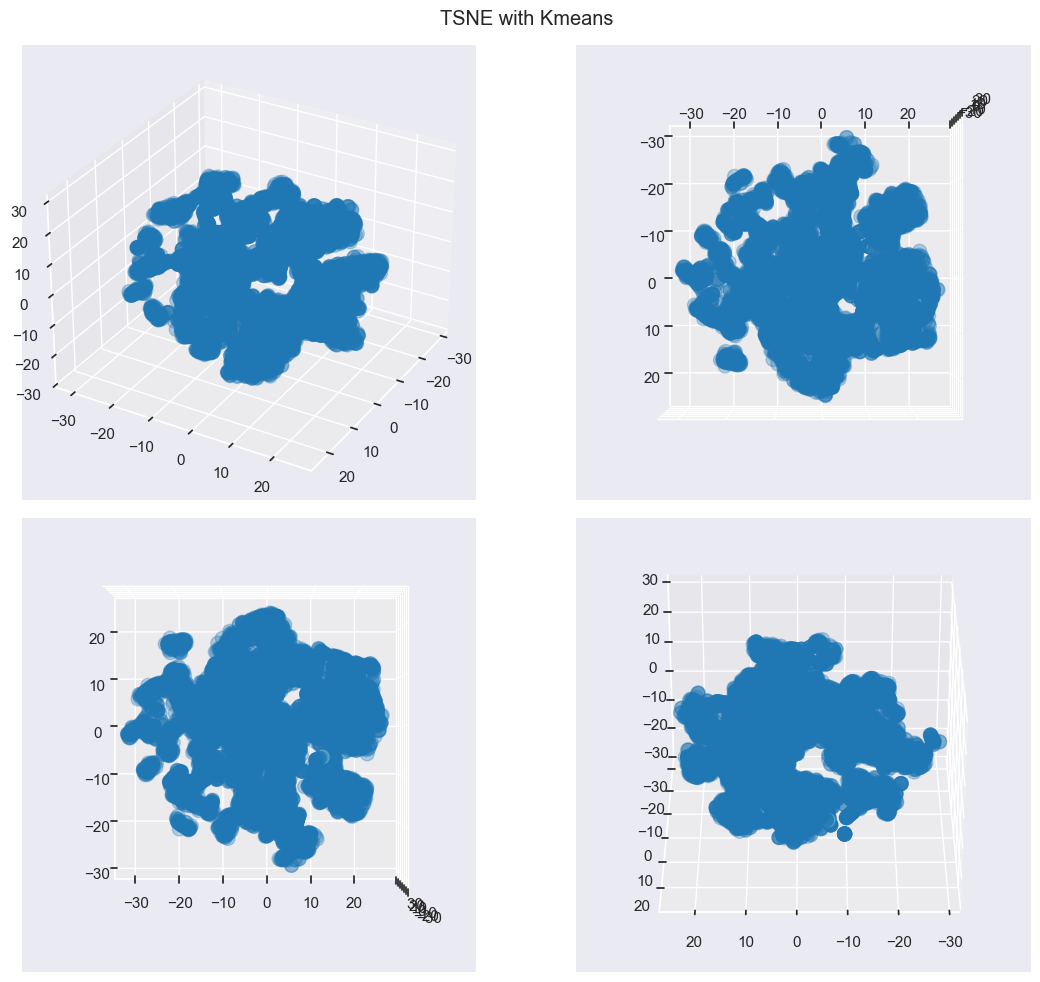

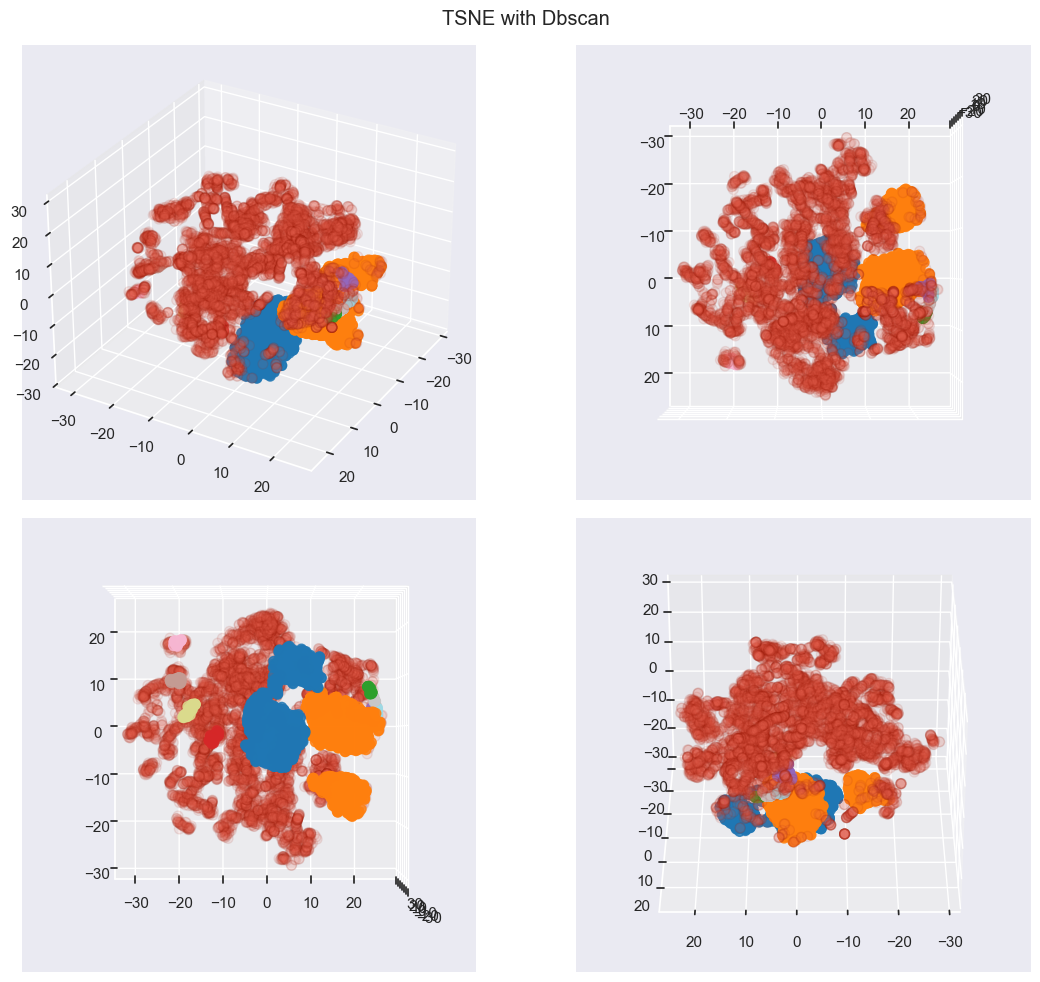

Explained Variance Ratio (PCA): 0.7397


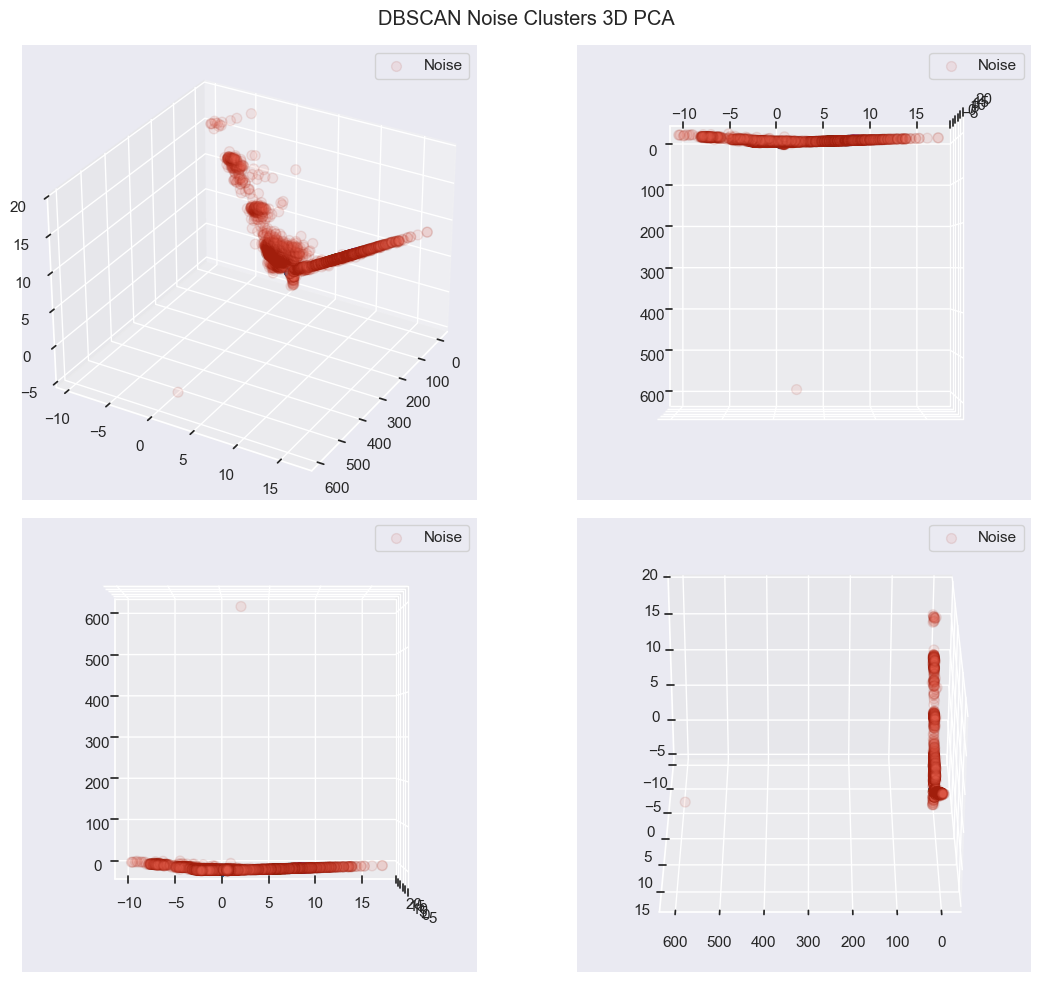

Explained Variance Ratio (PCA): 0.7397


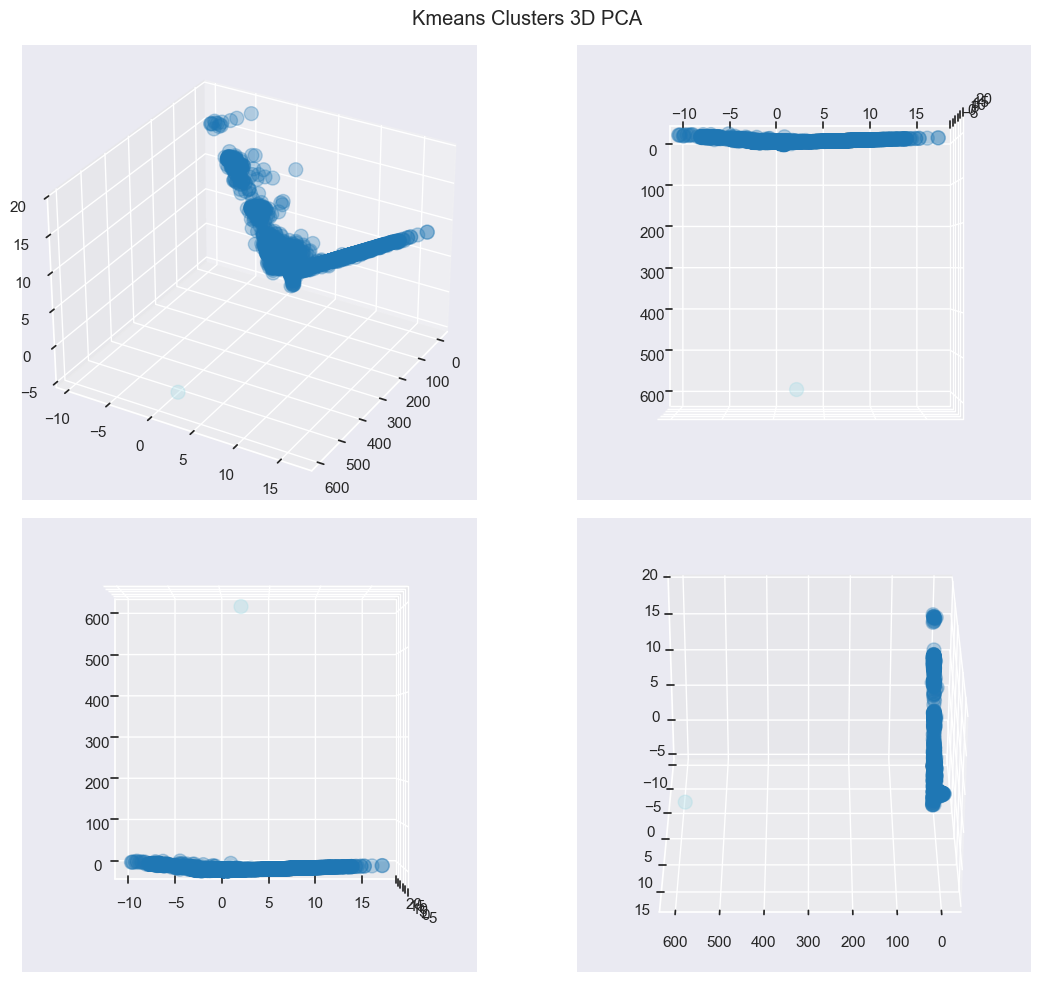

In [16]:
# Plot Clusters in 3D.
pc = PlotClusters(data_normal, scaler_type='standard', sample_size=10000)
pc.plot_tsne(apply_pca=False, n_clusters=2, lr='auto', perplexity=30, cluster_type='kmeans')
pc.plot_tsne(apply_pca=False, lr='auto', perplexity=30, cluster_type='dbscan', eps=0.5, min_samples=20)
pc.plot_dbscan(eps=0.5, min_samples=20)
pc.plot_kmeans(n_clusters=2)

# Analysis Threat Data

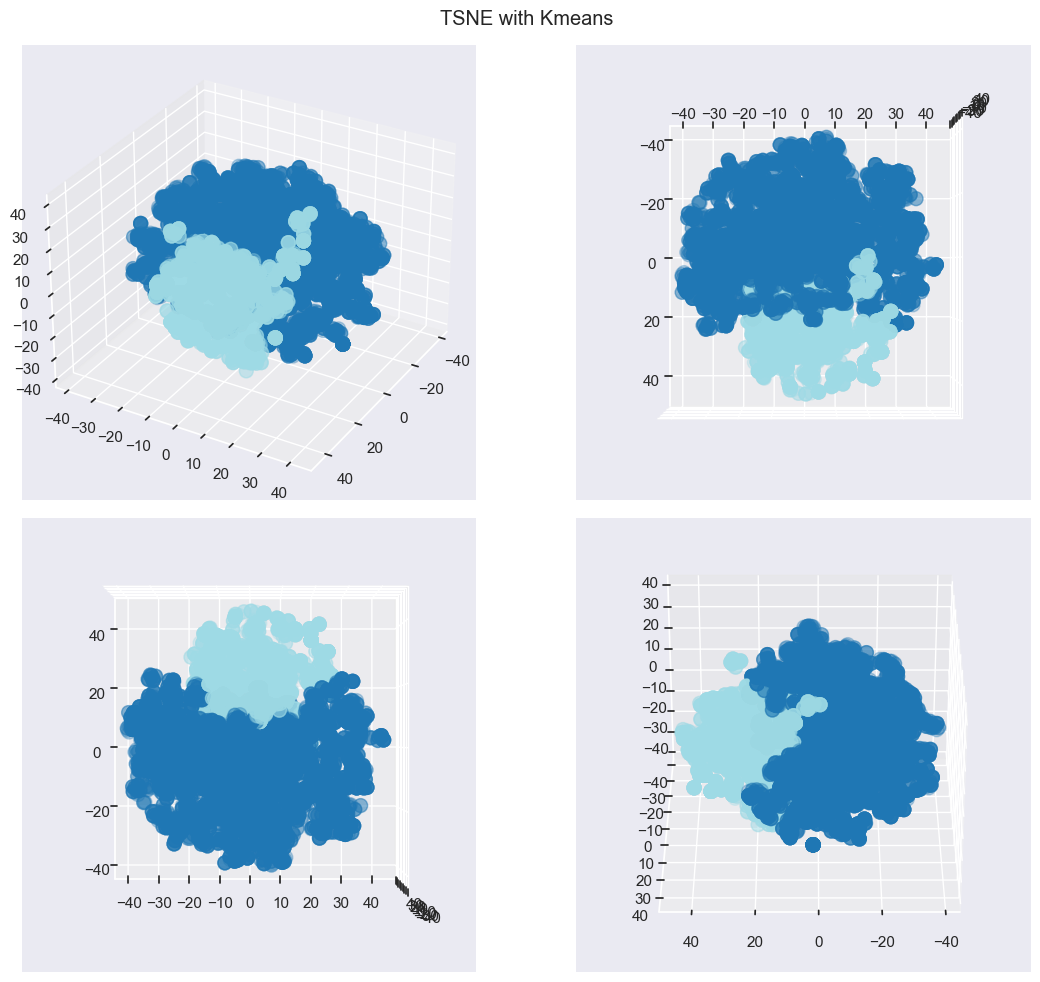

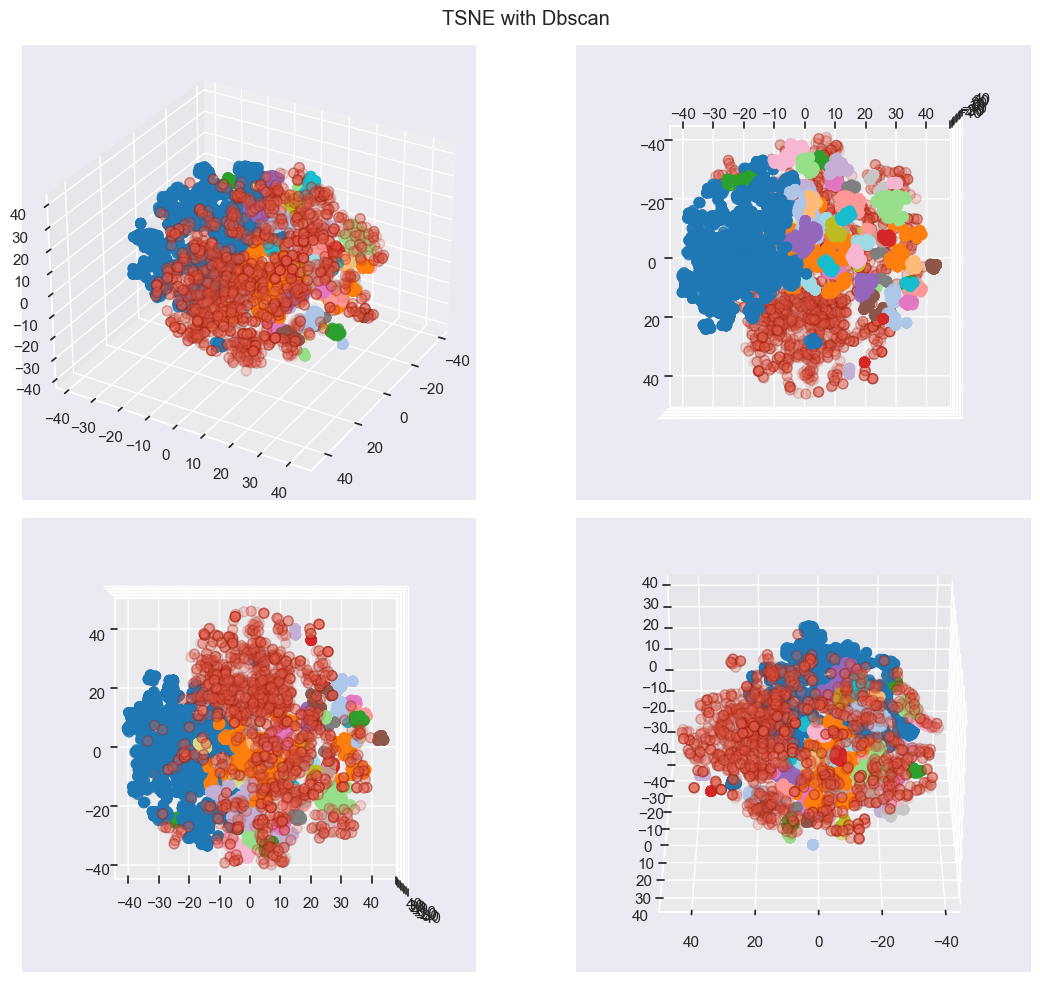

Explained Variance Ratio (PCA): 0.6710


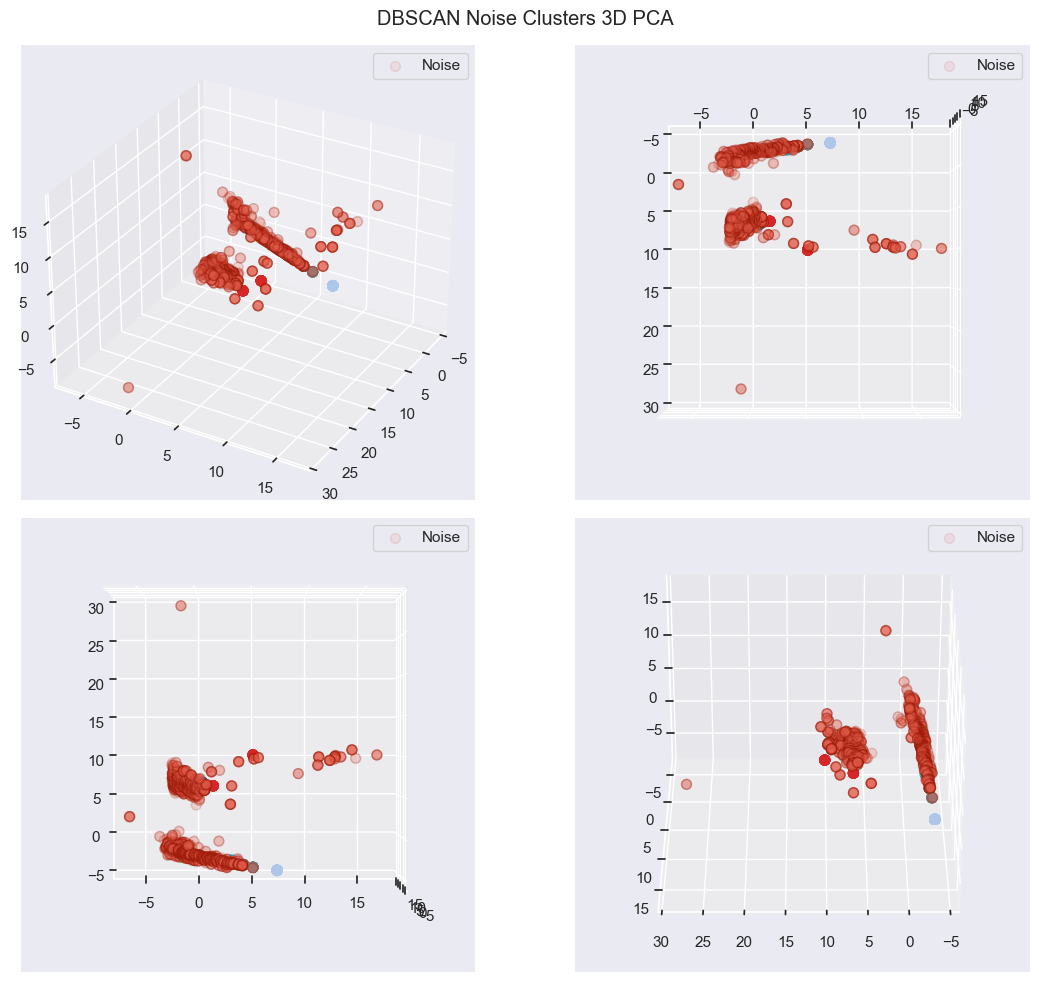

Explained Variance Ratio (PCA): 0.6710


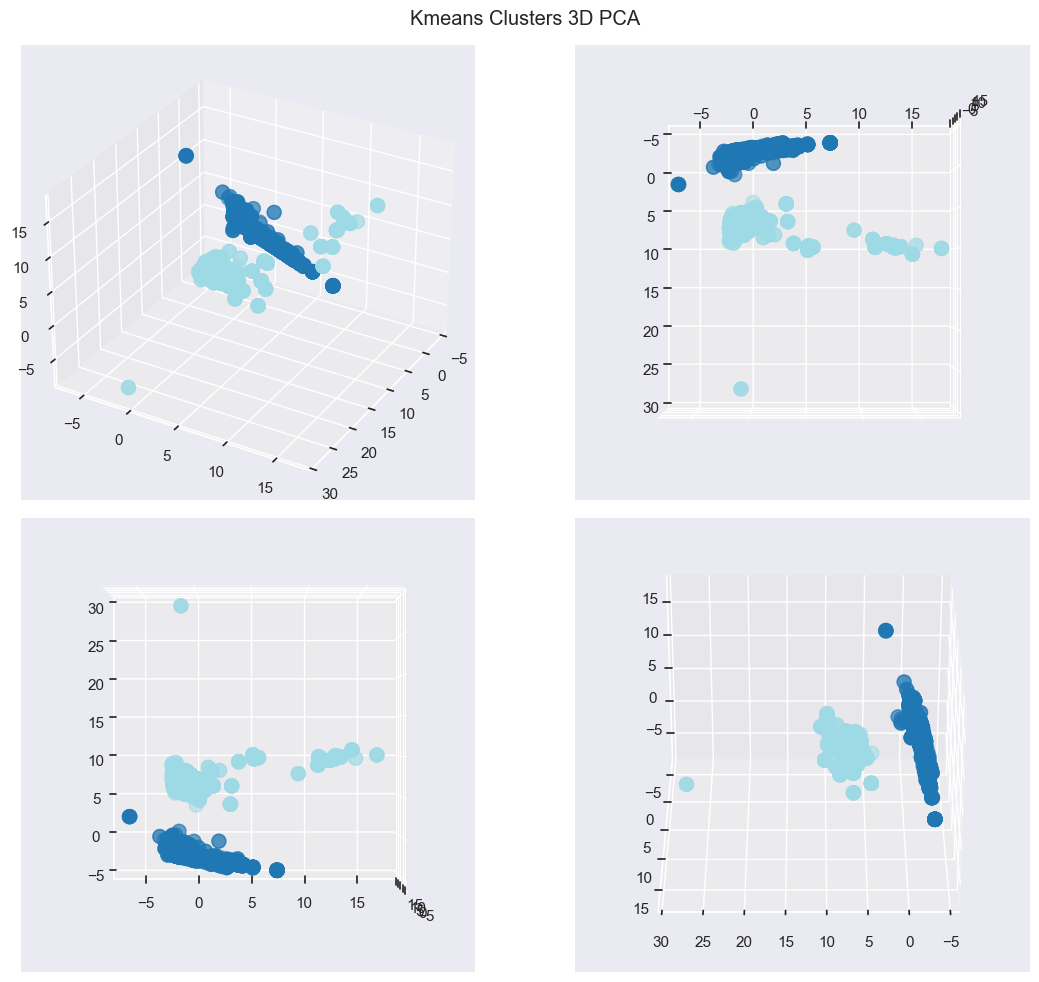

In [17]:
# Plot Clusters in 3D.
pc = PlotClusters(data_analysis, scaler_type='standard', sample_size=10000)
pc.plot_tsne(apply_pca=False, n_clusters=2, lr='auto', perplexity=30, cluster_type='kmeans')
pc.plot_tsne(apply_pca=False, lr='auto', perplexity=30, cluster_type='dbscan', eps=0.5, min_samples=20)
pc.plot_dbscan(eps=0.5, min_samples=20)
pc.plot_kmeans(n_clusters=2)